In [1]:
%matplotlib notebook

import os
import numpy as np
import matplotlib.pyplot as plt

from obspy import UTCDateTime, read, read_inventory
from obspy.clients.fdsn import Client
from datetime import timedelta

# 2011 Tohoku-oki earthquake

Define some parameters for ObsPy

In [2]:
client = Client("IRIS")
network = "JP"
station = "JOW"
inv_file = "JP_stations.xml"
sac_file = "tohoku.sac"

starttime = UTCDateTime("2011-03-11T05:46:23.200000Z") + timedelta(seconds=150)
endtime = starttime + timedelta(minutes=20)

Get the receiver station metadata and earthquake waveforms

In [3]:
client.get_stations(
    network=network, station=station, starttime=starttime, endtime=endtime, 
    channel="BH*", level="response", filename=inv_file
)

client.get_waveforms(
    network=network, station=station, location="*", channel="*", 
    starttime=starttime, endtime=endtime, attach_response=False,
    filename=sac_file
)

Remove instrument response and high-pass filter

In [4]:
stations = read_inventory(inv_file)

st = read(sac_file)
st.remove_response(inventory=stations.select(network=network), zero_mean=True)
st.filter("highpass", freq=0.1, corners=2, zerophase=True)
JOW = st.select(station=station)
print(JOW)

3 Trace(s) in Stream:
JP.JOW..BHE | 2011-03-11T05:48:53.200000Z - 2011-03-11T06:08:53.200000Z | 20.0 Hz, 24001 samples
JP.JOW..BHN | 2011-03-11T05:48:53.200000Z - 2011-03-11T06:08:53.200000Z | 20.0 Hz, 24001 samples
JP.JOW..BHZ | 2011-03-11T05:48:53.200000Z - 2011-03-11T06:08:53.200000Z | 20.0 Hz, 24001 samples


Quick inspection

<IPython.core.display.Javascript object>


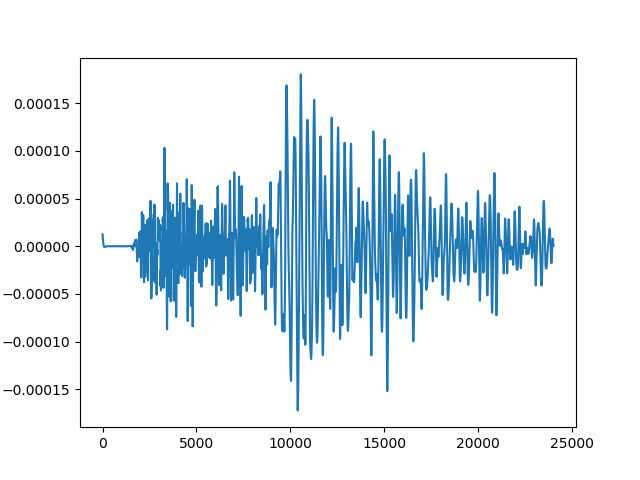

In [5]:
plt.figure()
plt.plot(JOW.select(channel="BHZ")[0].data)
plt.show()

Time to make art

<IPython.core.display.Javascript object>


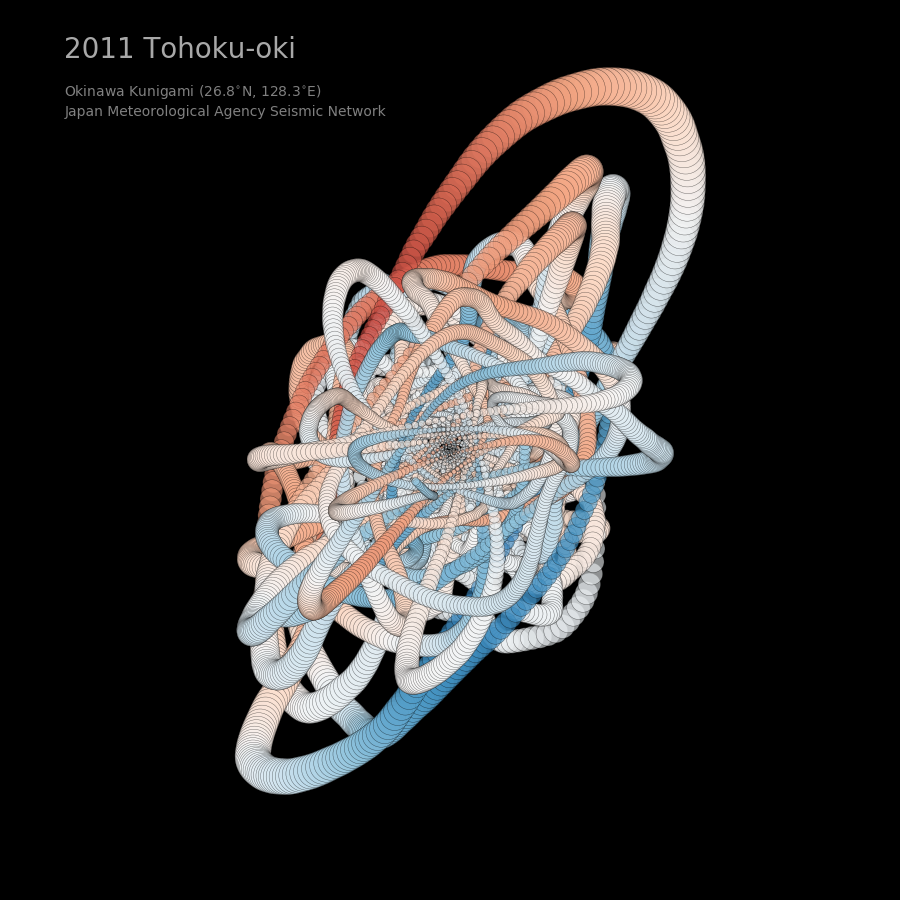

In [6]:
fig = plt.figure(figsize=(9, 9))

# Time range to select (don't include full coda)
start = 2000
stop = 15000
t_range = slice(start, stop)

# Select data
BHN = JOW.select(channel="BHN")[0].data[t_range]
BHE = JOW.select(channel="BHE")[0].data[t_range]
# Horizontal component
BHH = np.sqrt(BHN**2 + BHE**2)
# Scale N/E/horizontal components
BHN = BHN / BHH.std()
BHE = BHE / BHH.std()
BHH = BHH / BHH.std()
# Vertical component
BHZ = JOW.select(channel="BHZ")[0].data[t_range]
BHZ = BHZ / BHZ.std()

# Scaling of data points
sizes = 50 * np.power(BHH, 1.5) + 1

# Add axis
ax = fig.add_subplot(111)

# Scatter plot of N vs. E components, coloured by Z component
ax.scatter(
    BHE, BHN, c=BHZ, s=sizes,
    cmap="RdBu", alpha=0.6, vmin=-5, vmax=5, zorder=10,
    edgecolors="k", linewidths=0.3,
)

# Axis limits
ax.set_xlim((-7, 7))
ax.set_ylim((-7, 7))

# Black background
ax.set_facecolor("black")

# Add some description
ax.text(x=-6, y=6.1, s=r"2011 Tohoku-oki", color="lightgrey", fontsize=20, alpha=0.8)
ax.text(x=-6, y=5.5, s=r"Okinawa Kunigami ($26.8 ^{\circ}$N, $128.3 ^{\circ}$E)", color="grey")
ax.text(x=-6, y=5.2, s=r"Japan Meteorological Agency Seismic Network", color="grey")

# Make axis fill the entire figure
plt.subplots_adjust(top=1, bottom=0, left=0, right=1)

# Save to file
plt.savefig("tohoku.png")
plt.show()